In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import mean_absolute_error, r2_score

from src.config import FEATURES, TARGET, CV_MAE
from src.prep import clean_and_engineer


In [2]:
df_raw = pd.read_csv("../data/processed/filtered_91766.csv")
df = clean_and_engineer(df_raw)

X = df[FEATURES]
y = df[TARGET]

print("X shape:", X.shape)
print("y mean:", y.mean())


X shape: (380, 5)
y mean: 691492.5421052632


In [3]:
model = joblib.load("../app/xgb_final_model.pkl")
print(model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [4]:
pred = model.predict(X)

print("MAE (full data):", mean_absolute_error(y, pred))
print("R2  (full data):", r2_score(y, pred))

MAE (full data): 44313.670394736844
R2  (full data): 0.8370937932448959


In [5]:
eval_df = df.copy()
eval_df["Predicted"] = pred
eval_df["Residual"] = eval_df["Total Value"] - eval_df["Predicted"]
eval_df["AbsError"] = eval_df["Residual"].abs()
eval_df["PctError"] = eval_df["AbsError"] / eval_df["Total Value"]

eval_df[["Total Value", "Predicted", "Residual", "AbsError", "PctError"]].head()


,Total Value,Predicted,Residual,AbsError,PctError
6,279565.0,292725.59375,-13160.59375,13160.59375,0.047075
7,520436.0,509366.37500,11069.62500,11069.62500,0.021270
8,416177.0,509366.37500,-93189.37500,93189.37500,0.223918
9,635961.0,509366.37500,126594.62500,126594.62500,0.199060
10,415191.0,509366.37500,-94175.37500,94175.37500,0.226824


In [7]:
def label_valuation(actual, predicted, mae=CV_MAE):
    if actual > predicted + mae:
        return "Overvalued"
    elif actual < predicted - mae:
        return "Undervalued"
    else:
        return "Fairly priced"


In [8]:
import shap
print("SHAP version:", shap.__version__)


SHAP version: 0.50.0


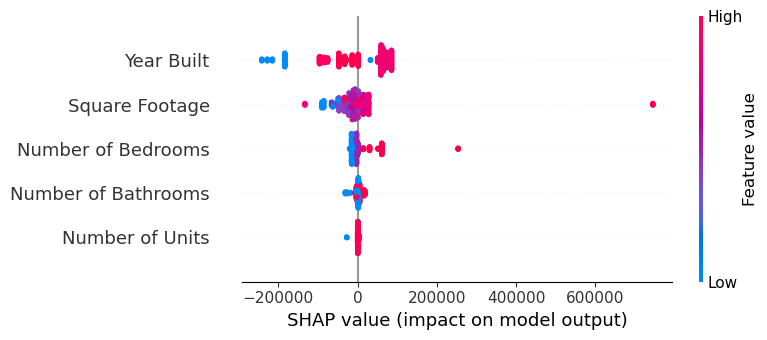

In [10]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)